In [1]:
import nest
import numpy as np
import pandas as pd
import sys
import os

import time
import datetime

from tinydb import TinyDB, Query

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib notebook

<IPython.core.display.Javascript object>


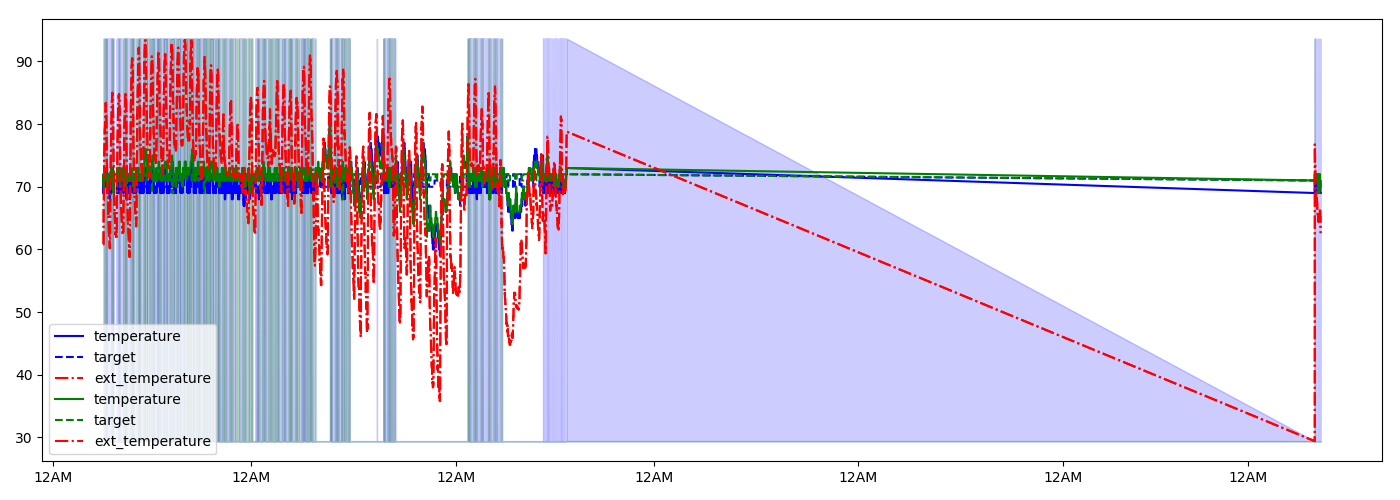

In [2]:
root_dir = os.path.join(os.path.expanduser("~"), 'nest_logger')
db = TinyDB(os.path.join(root_dir, 'db.json'))

df = pd.DataFrame(db.all())
df.last_connection = pd.to_datetime(df.last_connection)
df.request_time = pd.to_datetime(df.request_time)

df['cooling'] = df.hvac_state == 'cooling'


min_temp = min(df.temperature.min(), df.ext_temperature.min(), df.target.min())
max_temp = max(df.temperature.max(), df.ext_temperature.max(), df.target.max())   

plt.figure(figsize=[14,5])

ax = plt.gca()

for name, ls, c in zip(['Upstairs', 'Downstairs'], ['-','-.'], ['b', 'g']):

    pdf = df[df.name == name]
    plt.plot(pdf.request_time, pdf.temperature, '-', c=c)
    plt.plot(pdf.request_time, pdf.target, '--', c=c)
    plt.plot(pdf.request_time, pdf.ext_temperature, '-.', c='r')
    
    times = pdf.request_time.astype(datetime.datetime).as_matrix()
    
    plt.fill_between(times, np.ones(pdf.shape[0])*min_temp, pdf.cooling*(max_temp-min_temp) + min_temp, alpha=0.2, color=c)


    myFmt = mdates.DateFormatter('%-I%p')
    ax.xaxis.set_major_formatter(myFmt)

    plt.legend()
    plt.tight_layout()

<IPython.core.display.Javascript object>


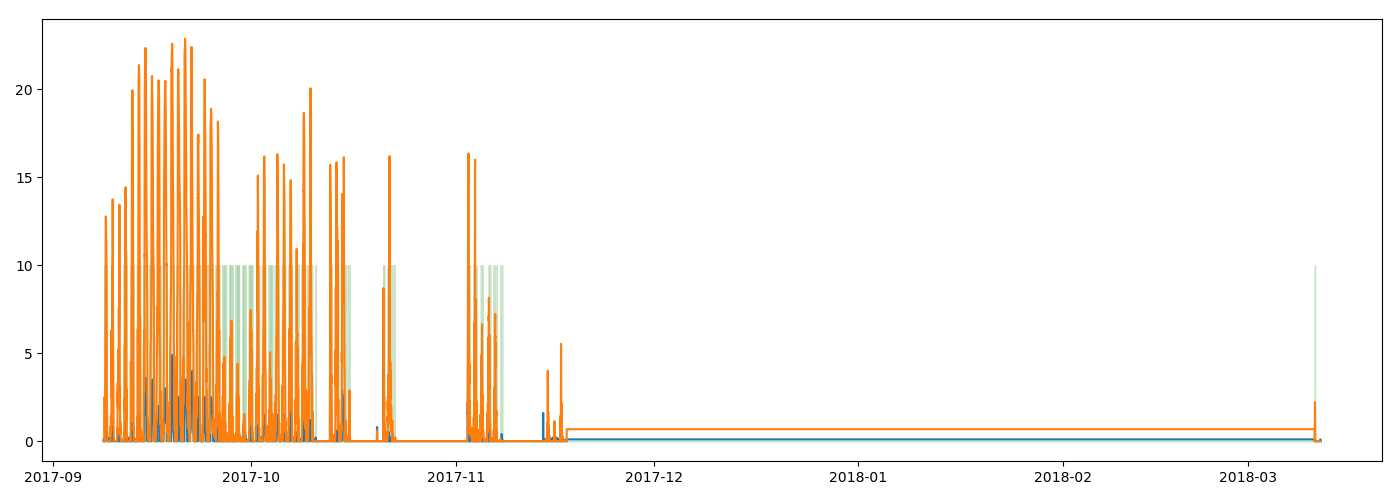

/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWi

In [3]:
plt.figure(figsize=[14,5])

df['setpoint_delta'] = df.temperature - df.target
df['setpoint_delta'][df.setpoint_delta < 0] = 0
df['setpoint_delta'][df.cooling == 0] = 0

df['ext_delta'] = df.ext_temperature - df.target
df['ext_delta'][df.ext_delta < 0] = 0
df['ext_delta'][df.cooling == 0] = 0


plt.plot(df.request_time, df.setpoint_delta.rolling(10).mean())
plt.plot(df.request_time, df.ext_delta.rolling(10).mean())

plt.fill_between(times, np.ones(pdf.shape[0])*0, pdf.cooling*10, alpha=0.2, color=c)

plt.tight_layout()

<IPython.core.display.Javascript object>


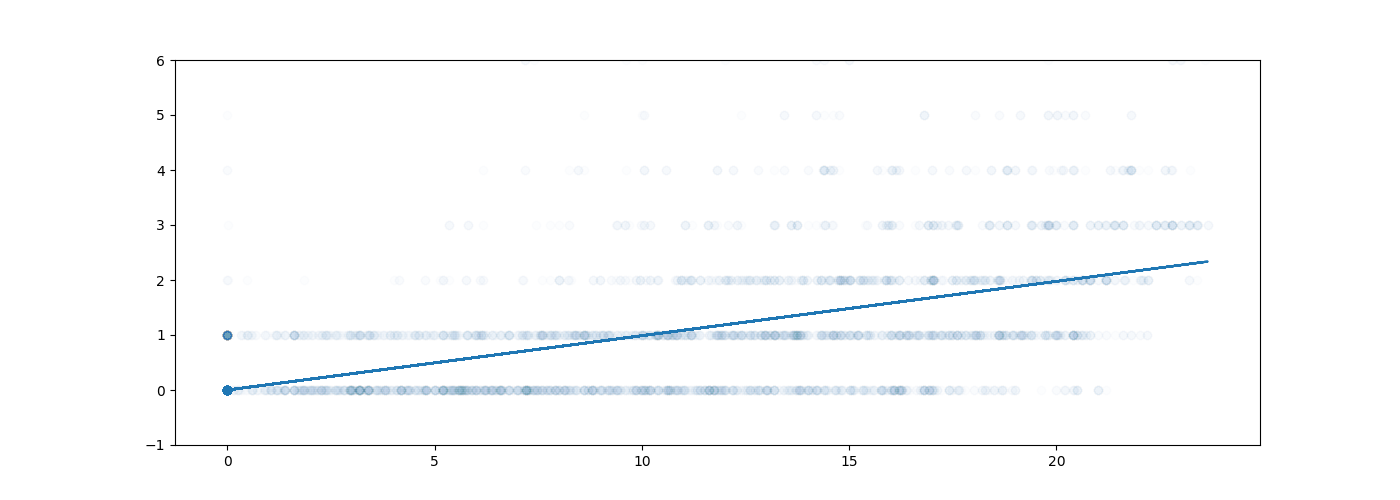

/home/brian/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(-1, 6)

In [12]:
plt.figure(figsize=[14,5])


import statsmodels.api as sm


X = df.ext_delta 
y = df.setpoint_delta

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

plt.plot(X, predictions)

plt.scatter(df.ext_delta, df.setpoint_delta, alpha=0.01)
plt.ylim(-1,6)